# TITLE:
 Time Series Forecasting & Predictive Model Building for Store Sales at Favorita Grocery Retailer.

# BUSINESS UNDERSTANDING: 
Corporation Favorita a large and popular grocery retailer in Ecuador is seeking to enhance its sales forcasting capabilities for all items in the store. Accurate predictions of sales is important for effective inventory management, optimizing promotional strategies,improving resuorce allocationand enhanicng decision making. In order to do this, a robust  time series model that can predict the unit sales of items will be developed. The model will leverage on historical data including dates,store information, product details and promotion indicators to provide insights into sales patterrn for the future.

# AIM:
The goal for this project is to build a robust time series forcasting model that can accurately predict the unit sales of items in the store.

# File Descriptions and Data Field Information

* train.csv

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

store_nbr identifies the store at which the products are sold.

family identifies the type of product sold.

sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.


* test.csv

The test data, having the same features as the training data. You will predict the target sales for the dates in this file.

The dates in the test data are for the 15 days after the last date in the training data.


* transaction.csv

Contains date, store_nbr and transaction made on that specific date.
sample_submission.csv


A sample submission file in the correct format.
stores.csv

Store metadata, including city, state, type, and cluster.

cluster is a grouping of similar stores.


* oil.csv

Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)


* holidays_events.csv

Holidays and Events, with metadata
NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).
Additional Notes

Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# HYPOTHESIS:
Null Hypothesis: The promotional activities do not have a significant impact on store sales at Corporation Favorita.

Alternative Hypothesis: The promotional activities  have a significant impact on store sales at Corporation Favorita.

## ANALYTICAL QUESTIONS
1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3.  Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?




## DATA IMPORTATION

In [ ]:
#installing packages for creating connections
%pip install pyodbc
%pip install python-dotenv

#packages for visualization
%pip install --upgrade nbformat


In [60]:
#Importing all necessary packages
import pyodbc

#import the dotenv_values function from the dotenv package
from dotenv import dotenv_values

#importing data handling packages
import pandas as pd
import numpy as np
import zipfile

#importing libraries for EDAs/visualization
import matplotlib.pyplot as mplot
import seaborn as sns
import plotly.express as px
%matplotlib inline 

#importing statistical tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import ttest_ind


import warnings
warnings.filterwarnings('ignore')

Create a connection by accessing your connection string with your defined environment variables

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("server")
database = environment_variables.get("database")
username = environment_variables.get("username")
password = environment_variables.get("password")


connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'

In [4]:
#creating a connection
connection = pyodbc.connect(connection_string)

Loading the dataset from remote server which contains 3 table

In [5]:
#loading first table (Oil Table)
query ="Select * from dbo.oil"
Oil_table =pd.read_sql(query,connection)
Oil_table.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [6]:
#loading second table (Holiday Table)
query = 'Select * from dbo.holidays_events'
Holiday_table = pd.read_sql(query,connection)
Holiday_table.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
#loading third table (Store Table)
query = 'Select * from dbo.stores'
store_table = pd.read_sql(query,connection)
store_table.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Loading dataset from Github Repository

In [8]:
# Extracting ZIP file
with zipfile.ZipFile('C:/Users/baakw/Downloads/store-sales-forecasting.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_folder')

# Read individual CSV files
train_data = pd.read_csv('extracted_folder/train.csv')
transactions_data = pd.read_csv('extracted_folder/transactions.csv')


Train Dataset

In [9]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


Transaction data

In [10]:
transactions_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


Test Dataset

In [11]:
test_data = pd.read_csv("C:/Users/baakw/Downloads/test.csv")
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


## DATA EXPLORATION, PREPROCESSING & CLEANING

a. Shape of Datasets

In [12]:
# Get the shape of each dataset
shape_df1 = Oil_table.shape
shape_df2 = Holiday_table.shape
shape_df3 = store_table.shape
shape_df4 = train_data.shape
shape_df5 = transactions_data.shape
shape_df6 = test_data.shape

# Print the shapes
print("Number of rows and columns of Oil dataset:", shape_df1)
print("Number of rows and columns of Holiday dataset:", shape_df2)
print("Number of rows and columns of Stores dataset:", shape_df3)
print("Number of rows and columns of train dataset:", shape_df4)
print("Number of rows and columns of transaction dataset:", shape_df5)
print("Number of rows and columns of test dataset:", shape_df6)

Number of rows and columns of Oil dataset: (1218, 2)
Number of rows and columns of Holiday dataset: (350, 6)
Number of rows and columns of Stores dataset: (54, 5)
Number of rows and columns of train dataset: (3000888, 6)
Number of rows and columns of transaction dataset: (83488, 3)
Number of rows and columns of test dataset: (28512, 5)


* The train dataset has a larger number of rows than the test dataset. Also number of columns in the test dataset has reduced by 1 as compared to the train dataset.

* These observations are expected because more often a train dataset is larger than a test dataset to provide enough data for a more accurate model performance.

* The missing column from the test dataset is the output to be predicted by the model and hence not needed in it.

b. Information on Columns of Dataset

In [13]:
#function to display column information of various dataset
def column_info(dataframe_name, dataframe):
    print(f'Datatypes for the {dataframe_name} dataframe:')
    print(dataframe.info())
    print('==='*14)

#stating column information of the dataframes
column_info('Train', train_data)
print()
column_info('Test', test_data)
print()
column_info('Transaction', transactions_data)
print()
column_info('Holiday', Holiday_table)
print()
column_info('Oil', Oil_table)
print()
column_info('Stores', store_table)

Datatypes for the Train dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None

Datatypes for the Test dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None

Datatypes for the Transaction dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex:

Train Dataframe
*  This dataframe has 3000888 entries/rows and 6 columns. Columns include id,date,store_nbr,family,sales and onpromotion.

*  date column format is an object and ideallys should be in datetime format for easy time series analysis.

Do so for rest of dataframes.


c. Changing the 'date' column format to datetime

In [14]:
# Changing the 'date' column in the datasets to datetime format
# Train dataframe
train_data['date'] = pd.to_datetime(train_data['date'])

# Test dataset
test_data['date'] = pd.to_datetime(test_data['date'])

# Holiday Events dataset
Holiday_table['date'] = pd.to_datetime(Holiday_table['date'])

# Oil dataset
Oil_table['date'] = pd.to_datetime(Oil_table['date'])

# Transactions dataset
transactions_data['date'] = pd.to_datetime(transactions_data['date'])

In [16]:
#Checking if date format has been changed
print('Date Column Data Type After Transformation:') 
print('==='*14)
print("Train dataset:", train_data['date'].dtype)
print("Test dataset:", test_data['date'].dtype)
print("Holiday Events dataset:", Holiday_table['date'].dtype)
print("Oil dataset:", Oil_table['date'].dtype)
print("Transactions dataset:", transactions_data['date'].dtype)

Date Column Data Type After Transformation:
Train dataset: datetime64[ns]
Test dataset: datetime64[ns]
Holiday Events dataset: datetime64[ns]
Oil dataset: datetime64[ns]
Transactions dataset: datetime64[ns]


In [17]:
#checking start date and end date of dataframe
print(f"Date range of train dataframe      : {train_data['date'].min()} to {train_data['date'].max()}")
print(f"Date range of test dataframe       :{test_data['date'].min()} to {test_data['date'].max()}")
print(f"Date range of transaction dataframe:{transactions_data['date'].min()} to {transactions_data['date'].max()}")
print(f"Date range of holiday dataframe    : {Holiday_table['date'].min()} to {Holiday_table['date'].max()}")
print(f"Date range of oil dataframe        : {Oil_table['date'].min()} to {Oil_table['date'].max()}")


Date range of train dataframe      : 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Date range of test dataframe       :2017-08-16 00:00:00 to 2017-08-31 00:00:00
Date range of transaction dataframe:2013-01-01 00:00:00 to 2017-08-15 00:00:00
Date range of holiday dataframe    : 2012-03-02 00:00:00 to 2017-12-26 00:00:00
Date range of oil dataframe        : 2013-01-01 00:00:00 to 2017-08-31 00:00:00


d. Checking for Missing values in datasets

In [18]:
#For missing values in the various datasets
#function to display column information of various dataset
def column_info(dataframe_name, dataframe):
    print(f'Missing values for the {dataframe_name} dataframe:')
    print(dataframe.isna().sum())
    print('==='*14)


#stating dataframes to be checked
column_info('Train', train_data)
print()
column_info('Test', test_data)
print()
column_info('Transaction', transactions_data)
print()
column_info('Holiday', Holiday_table)
print()
column_info('Oil', Oil_table)
print()
column_info('Stores', store_table)


Missing values for the Train dataframe:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing values for the Test dataframe:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing values for the Transaction dataframe:
date            0
store_nbr       0
transactions    0
dtype: int64

Missing values for the Holiday dataframe:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing values for the Oil dataframe:
date           0
dcoilwtico    43
dtype: int64

Missing values for the Stores dataframe:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


* It was observed that only the oil dataframe had 43 missing values in the oil prices(dcoilwtico) column.

e. Summary Statistics of the Datasets

In [20]:
# function to display summary statistics of various dataset
def column_info(dataframe_name, dataframe):
    print(f'Summary Statistics for  the {dataframe_name} dataframe:')
    print(dataframe.describe())
    print('==='*14)

#stating dataframes to be checked
column_info('Train', train_data)
print()
column_info('Test', test_data)
print()
column_info('Transaction', transactions_data)
print()
column_info('Holiday', Holiday_table)
print()
column_info('Oil', Oil_table)
print()
column_info('Stores', store_table)

Summary Statistics for  the Train dataframe:
                 id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703088384  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.502218e+05            2014-02-26 18:00:00  1.400000e+01   
50%    1.500444e+06            2015-04-24 12:00:00  2.750000e+01   
75%    2.250665e+06            2016-06-19 06:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000e+01   
std    8.662819e+05                            NaN  1.558579e+01   

              sales   onpromotion  
count  3.000888e+06  3.000888e+06  
mean   3.577757e+02  2.602770e+00  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    1.100000e+01  0.000000e+00  
75%    1.958473e+02  0.000000e+00  
max    1.247170e+05  7.410000e+02  
std    1.101998e+03  1.221888e+01  

Summary Statistic

* dcoilwtico (oil prices)

The mean/average oil price is approximately 67.71 with a standard deviation around 25.63 which indicates variability in the prices of oil.
The minimum oil price is 26.19 while the maximum oil price is 110.62

In [21]:
#Setting the date column as the index
Oil_table.set_index('date', inplace=True)
train_data.set_index('date', inplace=True)

In [40]:
#separating year, month and day column for analysis 
Oil_table['Year'] = Oil_table.index.year
Oil_table['Month'] = Oil_table.index.month
Oil_table['Day'] = Oil_table.index.day_name()

train_data['Year'] = train_data.index.year
train_data['Month'] = train_data.index.month
train_data['Day'] = train_data.index.day_name()



### UNIVARIATE ANALYSIS

Distribution of sales in train dataset

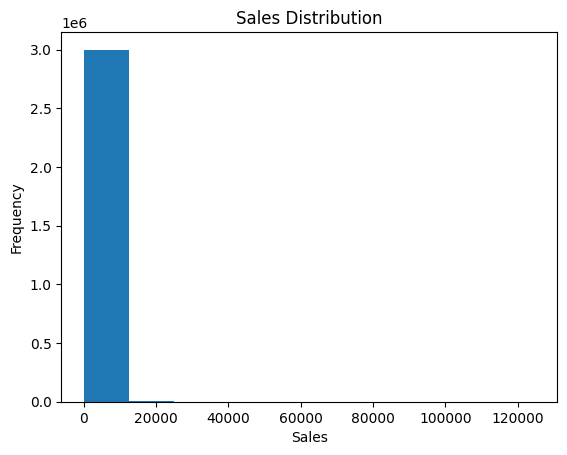

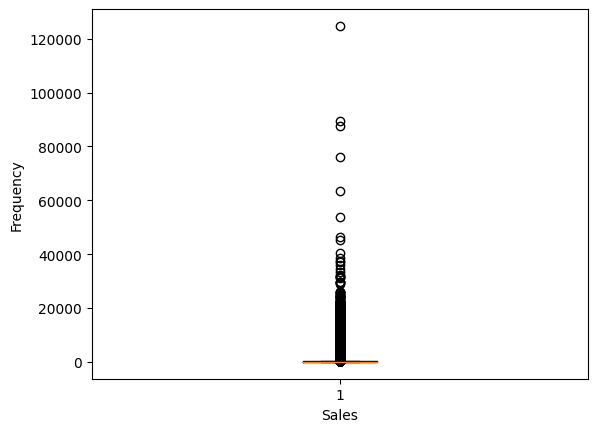

In [22]:
#Histoplot showing distribution of sales
mplot.hist(train_data['sales'])
mplot.title('Sales Distribution')
mplot.xlabel('Sales')
mplot.ylabel('Frequency')
mplot.show()

#Boxplot showing distribution of sales
mplot.boxplot(train_data['sales'])
mplot.ylabel('Frequency')
mplot.xlabel('Sales')
mplot.show()

Histoplot
* The peak in the distribution of sales values indicates that a majority of sales made fall within a certain range.

Boxplot
* This also shows that there are outliers in the dataset.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

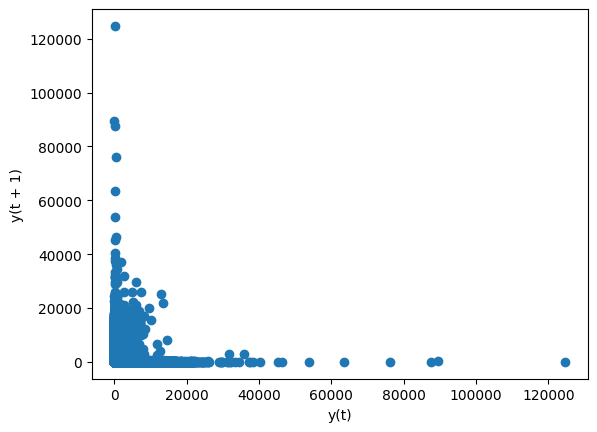

In [23]:
pd.plotting.lag_plot(train_data['sales'], lag=1)

### BIVARIATE ANALYSIS

Distribution of oil prices over the years in oil dataset

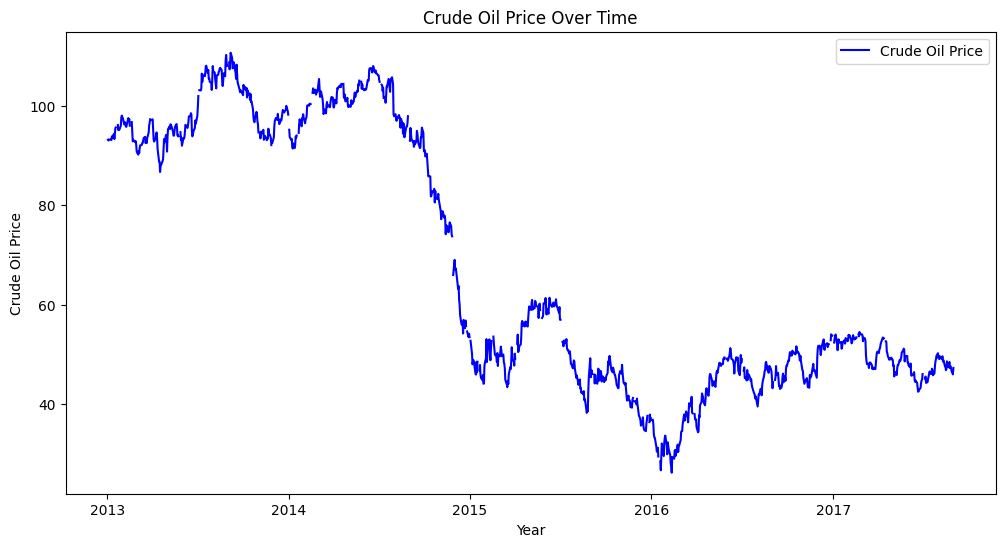

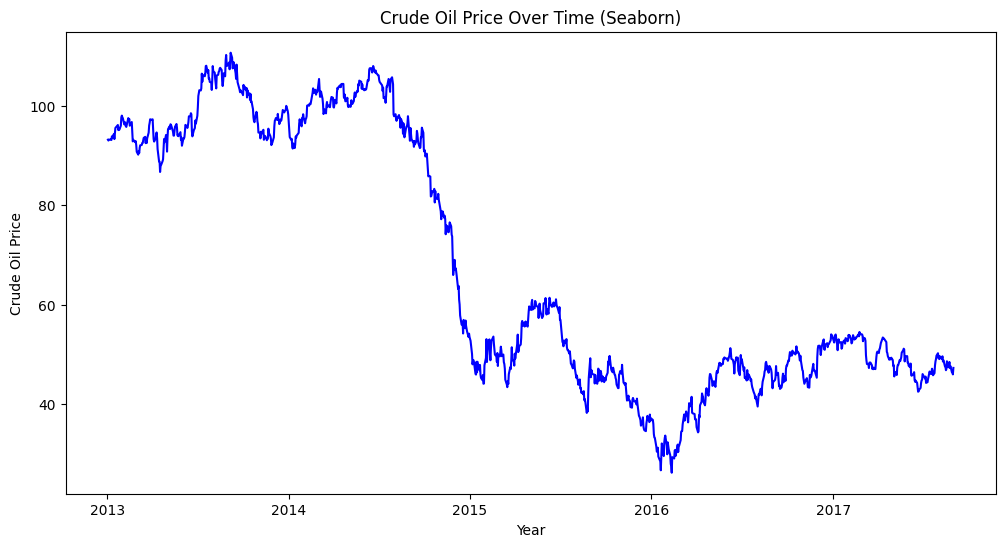

In [24]:
# Plot time series data
mplot.figure(figsize=(12, 6))
mplot.plot(Oil_table['dcoilwtico'], label='Crude Oil Price', color='blue')
mplot.title('Crude Oil Price Over Time')
mplot.xlabel('Year')
mplot.ylabel('Crude Oil Price')
mplot.legend()
mplot.show()

# Plot using Seaborn for additional insights
mplot.figure(figsize=(12, 6))
sns.lineplot(x=Oil_table.index, y=Oil_table['dcoilwtico'], color='blue')
mplot.title('Crude Oil Price Over Time (Seaborn)')
mplot.xlabel('Year')
mplot.ylabel('Crude Oil Price')
mplot.show()

Sales Performance over the years

<Axes: xlabel='date'>

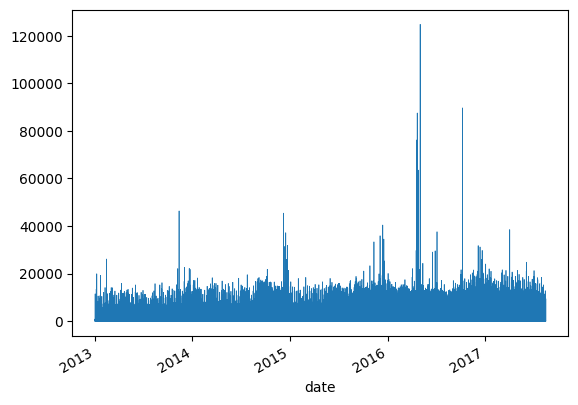

In [26]:
#sales made over the years in train dataset
train_data['sales'].plot(linewidth=0.5)


Distribution of sales over time

In [27]:
daily_sales = train_data.groupby('date')['sales'].sum()
daily_sales

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Name: sales, Length: 1684, dtype: float64

In [28]:
min_sales = daily_sales.min()
min_sales
print(f'Minimum daily sales over the years is {min_sales}')

Minimum daily sales over the years is 2511.618999


In [29]:
max_sales= daily_sales.max()
max_sales
print(f'Maximum daily sales over the years is {max_sales}')

Maximum daily sales over the years is 1463083.962459


<Axes: xlabel='date'>

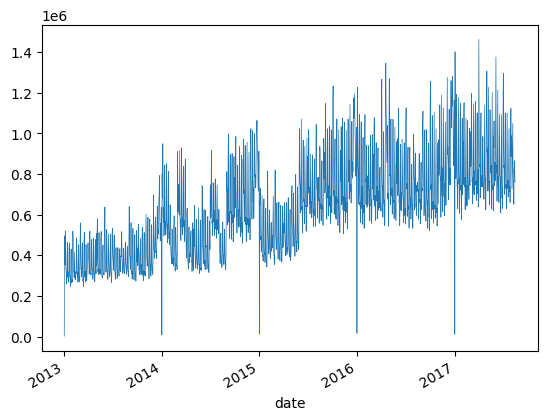

In [30]:
#plot showing trend in sales over time
daily_sales.plot(linewidth = 0.5)

This plot shows flactuation and variability in sales made across the year. Periods of highs and shows in the years tells a seasonality in the sales pattern.

Onpromotion over time

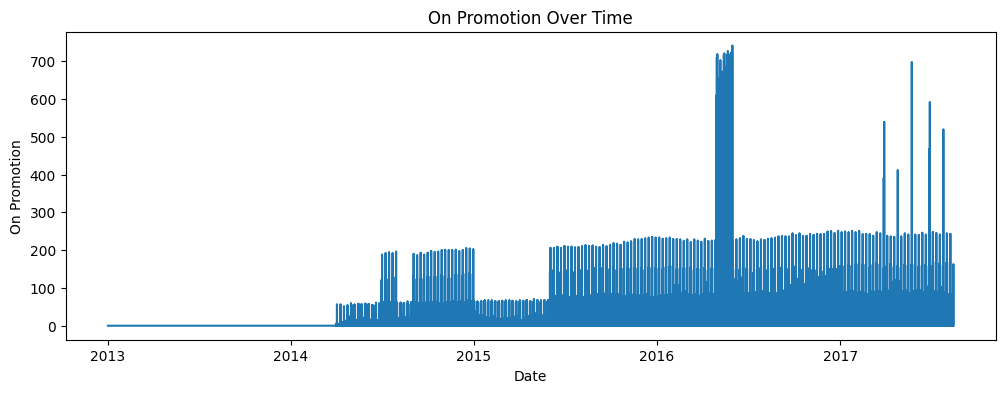

In [31]:
#Line chart for 'onpromotion'
mplot.figure(figsize=(12, 4))
mplot.plot(train_data.index, train_data['onpromotion'], linestyle='-')
mplot.title('On Promotion Over Time')
mplot.xlabel('Date')
mplot.ylabel('On Promotion')
mplot.show()

In [32]:
# Resample on a monthly frequency and count the occurrences of 'onpromotion'
onpromotion_resampled = train_data.resample('M')['onpromotion'].sum().reset_index()
 
# Plotting with Plotly
fig = px.line(onpromotion_resampled, x='date', y='onpromotion', title='On Promotion Over Time (Monthly Resampled)',
              labels={'onpromotion': 'Count'}, line_shape='linear')
 
fig.update_xaxes(title_text='Date', showgrid=False)
fig.update_yaxes(title_text='Count', showgrid=False)
 
# Add a range slider
fig.update_layout(xaxis_rangeslider_visible=True)
 
fig.show()

In [33]:
# Resample on a daily frequency and count the occurrences of 'onpromotion'
onpromotion_resampled = train_data.resample('D')['onpromotion'].sum().reset_index()
 
# Plotting with Plotly
fig = px.line(onpromotion_resampled, x='date', y='onpromotion', title='On Promotion Over Time (Daily Resampled)',
              labels={'onpromotion': 'Count'}, markers=False, line_shape='linear')
 
fig.update_xaxes(title_text='Date', showgrid=False)
fig.update_yaxes(title_text='Count', showgrid=False)
 
# Add a range slider
fig.update_layout(xaxis_rangeslider_visible=True)
 
fig.show()

### MULTIVARIATE ANALYSIS

In [62]:
# Set the display option to show float values to 3 decimal places avoiding scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

correlation = train_data.corr(numeric_only=True)
correlation

,id,store_nbr,sales,onpromotion,Year,Month
id,1.000,0.000,0.086,0.206,0.978,0.067
store_nbr,0.000,1.000,0.041,0.007,0.000,-0.000
sales,0.086,0.041,1.000,0.428,0.081,0.020
onpromotion,0.206,0.007,0.428,1.000,0.199,0.026
Year,0.978,0.000,0.081,0.199,1.000,-0.143
Month,0.067,-0.000,0.020,0.026,-0.143,1.000


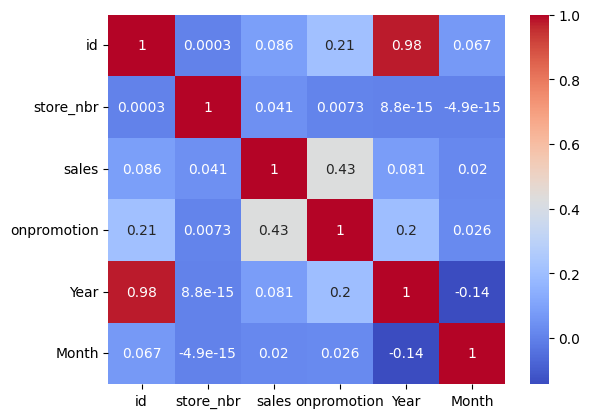

In [63]:
#plotting a heatmap
sns.heatmap(correlation, annot=True, cmap ='coolwarm')
mplot.show()

Handling Missing Data

In [43]:
#viewing missing values in the oil prices dataset
Oil_table.isna().sum()

dcoilwtico    0
Year          0
Month         0
Day           0
dtype: int64

In [36]:
# Visualizing the 'dcoilwtico' column to Identify a Strategy for Handling Missing Values
#Oil_table_reset = Oil_table.reset_index()

#fig = px.line(Oil_table_reset, x='date', y='dcoilwtico')
#fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
#fig.update_xaxes(rangeslider_visible=True)

#fig.show()


In [44]:
#flling missing values in the 'dcoilwtico' column using the backfill method
Oil_table['dcoilwtico']= Oil_table['dcoilwtico'].fillna(method='backfill')


In [45]:
#checking for missing values after using the backfill function
Oil_table['dcoilwtico'].isna().sum()

0

In [46]:
Oil_table.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1218 non-null   float64
 1   Year        1218 non-null   int32  
 2   Month       1218 non-null   int32  
 3   Day         1218 non-null   object 
dtypes: float64(1), int32(2), object(1)
memory usage: 38.1+ KB


In [47]:
Oil_table.head()

,dcoilwtico,Year,Month,Day
date,,,,
2013-01-01,93.139999,2013,1,Tuesday
2013-01-02,93.139999,2013,1,Wednesday
2013-01-03,92.970001,2013,1,Thursday
2013-01-04,93.120003,2013,1,Friday
2013-01-07,93.199997,2013,1,Monday


Merging datasets to create a new training dataframe 

In [48]:
#merging oil dataset and train dataset to create a new train dataframe
new_train_df = pd.merge(train_data, Oil_table, on='date', how='left')
new_train_df.head()

,id,store_nbr,family,sales,onpromotion,Year_x,Month_x,Day_x,dcoilwtico,Year_y,Month_y,Day_y
date,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013,1,Tuesday,93.139999,2013.0,1.0,Tuesday
2013-01-01,1,1,BABY CARE,0.0,0,2013,1,Tuesday,93.139999,2013.0,1.0,Tuesday
2013-01-01,2,1,BEAUTY,0.0,0,2013,1,Tuesday,93.139999,2013.0,1.0,Tuesday
2013-01-01,3,1,BEVERAGES,0.0,0,2013,1,Tuesday,93.139999,2013.0,1.0,Tuesday
2013-01-01,4,1,BOOKS,0.0,0,2013,1,Tuesday,93.139999,2013.0,1.0,Tuesday


In [49]:
#removing date column as index and adding it back as a regular column
new_train_df.reset_index(inplace=True)
new_train_df.head()

,date,id,store_nbr,family,sales,onpromotion,Year_x,Month_x,Day_x,dcoilwtico,Year_y,Month_y,Day_y
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013,1,Tuesday,93.139999,2013.0,1.0,Tuesday
1,2013-01-01,1,1,BABY CARE,0.0,0,2013,1,Tuesday,93.139999,2013.0,1.0,Tuesday
2,2013-01-01,2,1,BEAUTY,0.0,0,2013,1,Tuesday,93.139999,2013.0,1.0,Tuesday
3,2013-01-01,3,1,BEVERAGES,0.0,0,2013,1,Tuesday,93.139999,2013.0,1.0,Tuesday
4,2013-01-01,4,1,BOOKS,0.0,0,2013,1,Tuesday,93.139999,2013.0,1.0,Tuesday


In [50]:
#dropping some columns
columns_to_drop = ['Year_x', 'Month_x', 'Day_x', 'Year_y', 'Month_y', 'Day_y']
new_train_df.drop(columns=columns_to_drop, inplace=True)

In [51]:
#Checking if columns have been dropped
new_train_df.head()

,date,id,store_nbr,family,sales,onpromotion,dcoilwtico
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,93.139999
1,2013-01-01,1,1,BABY CARE,0.0,0,93.139999
2,2013-01-01,2,1,BEAUTY,0.0,0,93.139999
3,2013-01-01,3,1,BEVERAGES,0.0,0,93.139999
4,2013-01-01,4,1,BOOKS,0.0,0,93.139999


In [52]:
#to see rows and columns of new dataframe
new_train_df.shape

(3000888, 7)

In [53]:
# checking for null values
new_train_df.isna().sum()

date                0
id                  0
store_nbr           0
family              0
sales               0
onpromotion         0
dcoilwtico     857142
dtype: int64

In [54]:
#Dropping null values 
new_train_df.dropna(subset=['dcoilwtico'], inplace=True)

In [55]:
new_train_df.isna().sum()

date           0
id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
dtype: int64

In [56]:
#checking for duplicated values
new_train_df.duplicated().sum()

0

### STATIONARITY TEST

In [57]:
new_train_df[['dcoilwtico','sales','onpromotion','store_nbr']].describe().T

,count,mean,std,min,25%,50%,75%,max
dcoilwtico,2143746.0,67.887830,25.669538,26.190001,46.400002,53.299999,95.779999,110.620003
sales,2143746.0,321.629081,970.754915,0.000000,0.000000,10.000000,180.000000,124717.000000
onpromotion,2143746.0,2.831395,13.242526,0.000000,0.000000,0.000000,0.000000,741.000000
store_nbr,2143746.0,27.500000,15.585788,1.000000,14.000000,27.500000,41.000000,54.000000


In [ ]:
# Set the display option to show float values to 3 decimal places avoiding scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [ ]:
#performing an ADF test on sales column

#Extracting sales column from merged data
sales_df = new_train_df['sales']

#performing Augmented Dickey-fuller test on sales data
result = adfuller(sales_df)

#Extracting Test Statistics and P-value
test_statistic = result[0]
p_value = result[1]
critical_values = result[4]

#Printing test statistics and critical values
print(f"ADF Test Statistics: {test_statistic}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

#interpreting results
if p_value <= 0.05:
    print("Reject the null hypothesis: The sales data is stationary.")
else:
    print("Fail to reject the null hypothesis: The sales data is non-stationary.")



Stating null and alternative hypothesis for kpss stationarity test
* null hypothesis, Ho = Dataset is not stationary

* Alternative hypothesis, H1 = Dataset is stationary


In [58]:
# Select the column(s) for the stationary test from the merged dataset
columns_for_kpss = ['dcoilwtico', 'sales', 'onpromotion', 'store_nbr']

# Loop through selected columns and perform KPSS test
for column in columns_for_kpss:
    column_data = new_train_df[column]
    
# Perform KPSS test
    stats, p_value, lags, critical_values = kpss(column_data)
    
# Print the results
    print(f"KPSS Test for {column}:")
    print(f"Test Statistic: {stats}")
    print(f"P-value: {p_value}")
    print(f"Lags Used: {lags}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key}: {value}")
    
# Check the p-value against a significance level (e.g., 0.05)
    if p_value <= 0.05:
        print(f"Reject the null hypothesis: {column} data is stationary.")
    else:
        print(f"Fail to reject the null hypothesis: {column} data is non-stationary.")
    print("\n")


KPSS Test for dcoilwtico:
Test Statistic: 213.54894730279818
P-value: 0.01
Lags Used: 805
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Reject the null hypothesis: dcoilwtico data is stationary.


KPSS Test for sales:
Test Statistic: 155.60364259426467
P-value: 0.01
Lags Used: 498
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Reject the null hypothesis: sales data is stationary.


KPSS Test for onpromotion:
Test Statistic: 256.9031581898123
P-value: 0.01
Lags Used: 599
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Reject the null hypothesis: onpromotion data is stationary.


KPSS Test for store_nbr:
Test Statistic: 0.0002856041283703443
P-value: 0.1
Lags Used: 770
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Fail to reject the null hypothesis: store_nbr data is non-stationary.




SEASONAL DECOMPOSITION

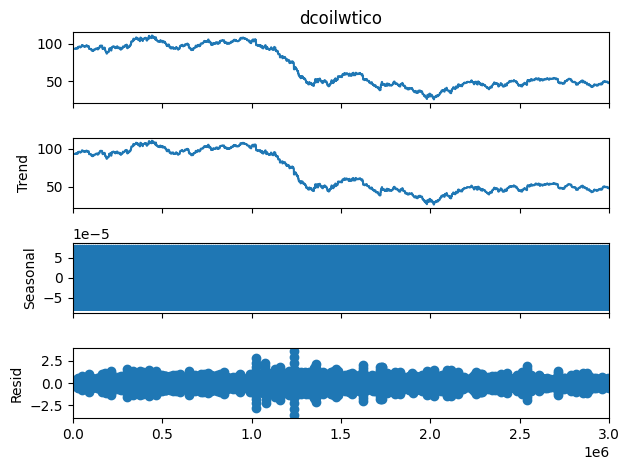

In [65]:
#%pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
tab_1= seasonal_decompose(new_train_df['dcoilwtico'], model='additive', period=12)
tab_1.plot()
mplot.show()

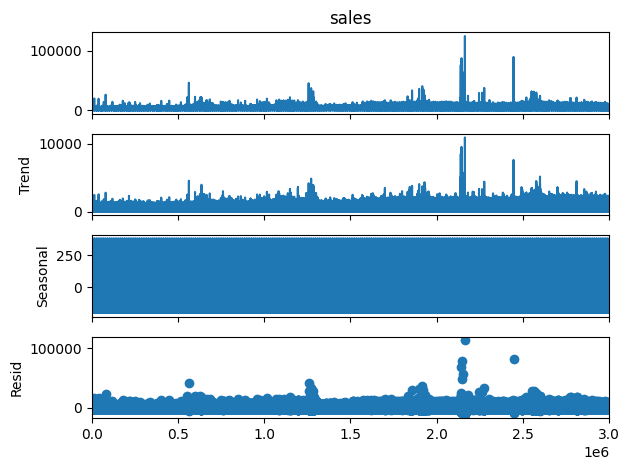

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose
tab_1= seasonal_decompose(new_train_df['sales'], model='additive', period=12)
tab_1.plot()
mplot.show()

### Hypothesis Testing and Answering analytical Questions

HYPOTHESIS:
* Null Hypothesis: The promotional activities do not have a significant impact on store sales at Corporation Favorita.

* Alternative Hypothesis: The promotional activities  have a significant impact on store sales at Corporation Favorita.


In [61]:
#defining variables to be used for hypothesis testing
onpromo_sales = new_train_df[new_train_df['onpromotion'] == 1]['sales']
not_onpromo_sales = new_train_df[new_train_df['onpromotion'] == 0]['sales']

#perfroming a t test to compare sales between onpromo_sales and not_onpromo sales
test_statistic, p_value = ttest_ind(onpromo_sales,not_onpromo_sales)

# Print the test result
print("Hypothesis Testing for Promotional Activities:")
print("Null Hypothesis (H0): The promotional activities do not have a significant impact on store sales.")
print("Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.")
print("-" * 50)
print("Test Statistic:", test_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print("Reject the null hypothesis. Promotional activities have a significant impact on store sales at Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis. Promotional activities do not have a significant impact on store sales at Corporation Favorita")

Hypothesis Testing for Promotional Activities:
Null Hypothesis (H0): The promotional activities do not have a significant impact on store sales.
Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.
--------------------------------------------------
Test Statistic: 165.49380173790135
P-value: 0.0
Reject the null hypothesis. Promotional activities have a significant impact on store sales at Corporation Favorita.


ANALYTICAL QUESTIONS

1. Is the train dataset complete (has all the required dates)?

In [76]:
# Defining the expected range of dates

#Resetting index to put date in a cloumn
train_data_reset = train_data.reset_index()

# The minimum date in the dataset is the start date
start_date = train_data_reset['date'].min() 

# The maximum date in the dataset is the end date
end_date = train_data_reset['date'].max()  

#
expected_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Check for missing dates
missing_dates = expected_dates[~expected_dates.isin(train_data_reset['date'])]

# Print missing dates
print("Missing Dates:")
print(missing_dates)


Missing Dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


2. Which dates have the lowest and highest sales for each year?


3.  Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?


FEATURE ENGINEERING

Separating day,month,year and day from date column in Train dataset

In [81]:
#separating year, month and day column for analysis 
new_train_df['Year'] = new_train_df['date'].year
new_train_df['Month'] = new_train_df['date'].month
new_train_df['Day'] = new_train_df['date'].day_name()

AttributeError: 'Series' object has no attribute 'year'

things to do after EDA
1.stationarity test
2.deal with missing data esp in oil data if you want to merge. You can join them to train dataset on inner join. In dealing with missing values it will be best to use backfill
3.decomposition


From mavis
in feature engineering, you can group columns by store id and location or store id and family to help with better prediction of item sold in store

it is best to split data on date ranges especially when u have inconsistent data
do not do normal train test split for a normal regression

